In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,\
roc_auc_score,roc_curve,recall_score,precision_score,classification_report,f1_score
from sklearn.model_selection import cross_val_score

from imblearn.under_sampling import *
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('poster')

import warnings
import time


* * * *

## Load Data

In [4]:
df = pd.read_csv("../data/df_baseline.csv")

In [5]:
df = df.sort_values(by=['artist']).reset_index(drop=True)
print(df.shape)
df.head()

(1083, 18)


,label,artist,album,genre,single_count,freq_billboard,freq_genius,freq_theSource,freq_xxl,rating_AOTY,rating_meta,rating_pitch,twitter,instagram,facebook,spotify,soundcloud,youtube
0,0,1GN,1 Girl Nation,pop,1,0,0,0,3,NaN,NaN,NaN,13,10323,0,5925,0,25490
1,1,2 Chainz,Based on a T.R.U. Story,hiphop,3,0,1,30,195,NaN,55.0,4.5,4213051,4566472,6145306,2647895,187250,2640612
2,1,21 Savage,Issa Album,hiphop,1,2,4,10,332,66.0,70.0,6.5,2246173,7445482,1134519,3864308,789270,3332058
3,0,5 Seconds of Summer,5 Seconds of Summer,pop,4,8,0,51,711,NaN,65.0,NaN,12606911,7310498,10296778,2969521,191358,4031726
4,1,6lack,Free 6lack,hiphop,2,0,1,6,99,NaN,NaN,NaN,456200,839246,303208,805720,266100,463168


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1083 entries, 0 to 1082
Data columns (total 18 columns):
label             1083 non-null int64
artist            1083 non-null object
album             1083 non-null object
genre             1083 non-null object
single_count      1083 non-null int64
freq_billboard    1083 non-null int64
freq_genius       1083 non-null int64
freq_theSource    1083 non-null int64
freq_xxl          1083 non-null int64
rating_AOTY       61 non-null float64
rating_meta       324 non-null float64
rating_pitch      220 non-null float64
twitter           1083 non-null int64
instagram         1083 non-null int64
facebook          1083 non-null int64
spotify           1083 non-null int64
soundcloud        1083 non-null int64
youtube           1083 non-null int64
dtypes: float64(3), int64(12), object(3)
memory usage: 152.4+ KB


In [7]:
df.describe()

,label,single_count,freq_billboard,freq_genius,freq_theSource,freq_xxl,rating_AOTY,rating_meta,rating_pitch,twitter,instagram,facebook,spotify,soundcloud,youtube
count,1083.000000,1083.000000,1083.000000,1083.000000,1083.000000,1083.000000,61.000000,324.000000,220.000000,1.083000e+03,1.083000e+03,1.083000e+03,1.083000e+03,1.083000e+03,1.083000e+03
mean,0.209603,2.595568,0.642659,1.395199,13.378578,232.204063,66.098361,71.015432,6.810000,8.162517e+05,1.148277e+06,9.392479e+05,4.052015e+05,2.045023e+05,5.766690e+05
std,0.407213,2.806590,3.372542,24.121972,40.525759,924.497039,16.944719,9.724840,1.360932,3.595182e+06,6.297742e+06,3.392730e+06,1.143469e+06,8.875424e+05,1.908113e+06
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,64.000000,65.000000,6.100000,3.949000e+03,0.000000e+00,1.013800e+04,7.023000e+03,0.000000e+00,0.000000e+00
50%,0.000000,2.000000,0.000000,0.000000,0.000000,6.000000,69.000000,72.500000,7.050000,4.024000e+04,3.099500e+04,7.855900e+04,4.727500e+04,1.736000e+03,1.924800e+04
75%,0.000000,4.000000,0.000000,0.000000,4.000000,65.500000,76.000000,78.000000,7.800000,2.889390e+05,3.010275e+05,4.527645e+05,2.269760e+05,3.220250e+04,2.148705e+05
max,1.000000,37.000000,73.000000,731.000000,200.000000,12802.000000,85.000000,92.000000,9.500000,5.696178e+07,1.366012e+08,6.167920e+07,1.382065e+07,9.710262e+06,2.367711e+07


* * * *

# Feature Preprocessing & Engineering

### Rating

#### Scaling

In [8]:
df['rating_pitch'] = df['rating_pitch'] * 10

In [9]:
df['rating_pitch'].head()

0     NaN
1    45.0
2    65.0
3     NaN
4     NaN
Name: rating_pitch, dtype: float64

In [10]:
def avg_rating():
    for i in range(len(df)):
        if np.isnan(df.loc[i, 'rating_meta']) == True:
            if np.isnan(df.loc[i, 'rating_pitch']) == True:
                if np.isnan(df.loc[i, 'rating_AOTY']) == True:
                    df.loc[i, 'rating'] = 0
                else:
                    df.loc[i, 'rating'] = df.loc[i, 'rating_AOTY']
            else:
                df.loc[i, 'rating'] = df.loc[i, 'rating_pitch']
        else:
            df.loc[i, 'rating'] = df.loc[i, 'rating_meta']
            
    return df.head()

In [11]:
avg_rating()

,label,artist,album,genre,single_count,freq_billboard,freq_genius,freq_theSource,freq_xxl,rating_AOTY,rating_meta,rating_pitch,twitter,instagram,facebook,spotify,soundcloud,youtube,rating
0,0,1GN,1 Girl Nation,pop,1,0,0,0,3,NaN,NaN,NaN,13,10323,0,5925,0,25490,0.0
1,1,2 Chainz,Based on a T.R.U. Story,hiphop,3,0,1,30,195,NaN,55.0,45.0,4213051,4566472,6145306,2647895,187250,2640612,55.0
2,1,21 Savage,Issa Album,hiphop,1,2,4,10,332,66.0,70.0,65.0,2246173,7445482,1134519,3864308,789270,3332058,70.0
3,0,5 Seconds of Summer,5 Seconds of Summer,pop,4,8,0,51,711,NaN,65.0,NaN,12606911,7310498,10296778,2969521,191358,4031726,65.0
4,1,6lack,Free 6lack,hiphop,2,0,1,6,99,NaN,NaN,NaN,456200,839246,303208,805720,266100,463168,0.0


* * * *

# Data Preparation for Modeling

#### Genre `hiphop`, `R&B`, `Soul`, `Funk`, `Pop`

In [12]:
df = pd.get_dummies(df, columns=['genre'])

In [13]:
df.columns

Index(['label', 'artist', 'album', 'single_count', 'freq_billboard',
       'freq_genius', 'freq_theSource', 'freq_xxl', 'rating_AOTY',
       'rating_meta', 'rating_pitch', 'twitter', 'instagram', 'facebook',
       'spotify', 'soundcloud', 'youtube', 'rating', 'genre_Soul',
       'genre_funk', 'genre_hiphop', 'genre_pop', 'genre_rnb', 'genre_soul'],
      dtype='object')

#### Split train & test data 

In [14]:
feature_names = ['single_count', 
                 'freq_billboard', 'freq_genius', 'freq_theSource', 'freq_xxl',
                 'twitter', 'instagram', 'facebook',
                 'spotify', 'soundcloud', 'youtube',
                 'genre_funk', 'genre_hiphop', 'genre_pop', 'genre_rnb', 'genre_soul',
                 'rating'
                ]
dfX = df[feature_names].copy()
dfy = df['label'].copy()

In [15]:
dfX.tail()

,single_count,freq_billboard,freq_genius,freq_theSource,freq_xxl,twitter,instagram,facebook,spotify,soundcloud,youtube,genre_funk,genre_hiphop,genre_pop,genre_rnb,genre_soul,rating
1078,0,0,0,1,45,9660,0,83296,84892,6447,99022,0,0,1,0,0,0.0
1079,0,0,0,0,0,1803,3011,11537,5337,711,0,0,0,1,0,0,0.0
1080,5,0,0,0,0,312739,0,2118,183626,0,0,0,0,1,0,0,0.0
1081,3,2,1,0,315,3413328,5759232,8626519,6663594,1018428,14572408,0,0,1,0,0,0.0
1082,3,0,0,0,761,0,0,576,17285,0,29666,0,0,1,0,0,56.0


In [16]:
dfy.tail()

1078    0
1079    0
1080    0
1081    1
1082    0
Name: label, dtype: int64

In [17]:
X_train, X_test, y_train, y_test = train_test_split(dfX, dfy, test_size=0.25, random_state=0)

* * * *

# Adaboost with DecisionTree

In [18]:
from sklearn.tree import DecisionTreeClassifier

In [19]:
from sklearn.ensemble import AdaBoostClassifier
model_ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, random_state=0), 
                               algorithm="SAMME", n_estimators=100)
model_ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'),
          learning_rate=1.0, n_estimators=100, random_state=None)

In [20]:
print(confusion_matrix(y_train, model_ada.predict(X_train)))

[[633   8]
 [ 22 149]]


In [21]:
print(classification_report(y_train, model_ada.predict(X_train)))

             precision    recall  f1-score   support

          0       0.97      0.99      0.98       641
          1       0.95      0.87      0.91       171

avg / total       0.96      0.96      0.96       812



In [22]:
print(confusion_matrix(y_test, model_ada.predict(X_test)))

[[205  10]
 [ 14  42]]


In [23]:
print(classification_report(y_test, model_ada.predict(X_test)))

             precision    recall  f1-score   support

          0       0.94      0.95      0.94       215
          1       0.81      0.75      0.78        56

avg / total       0.91      0.91      0.91       271



In [24]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve(y_test, model_ada.predict_proba(X_test)[:, 1])

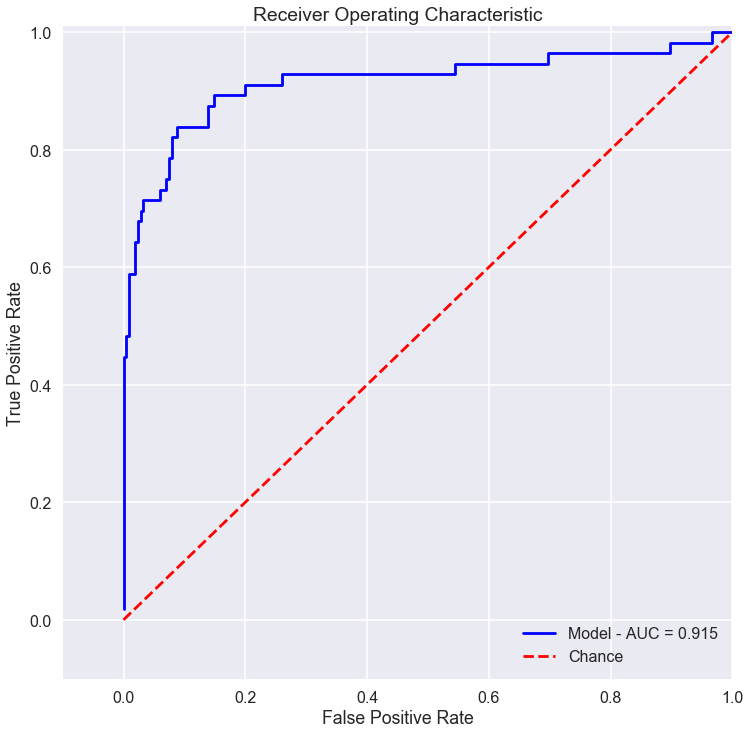

In [26]:
draw_roc_auc(model_ada)

In [27]:
for name, importance in zip(X_train.columns, model_ada.feature_importances_):
    print(name, importance)

single_count 0.07756005159307403
freq_billboard 0.0123296827137643
freq_genius 0.04162025811907911
freq_theSource 0.02535537793219789
freq_xxl 0.10752148475133032
twitter 0.08018752591580365
instagram 0.1039809492277445
facebook 0.02413255401147591
spotify 0.21064128737271726
soundcloud 0.11810927068901135
youtube 0.03456951636576168
genre_funk 0.029977575190011884
genre_hiphop 0.01119486157371242
genre_pop 0.03690614066848062
genre_rnb 0.004889323512787533
genre_soul 0.016681310938693936
rating 0.06434282942435347


# Undersampling

In [28]:
rus = RandomUnderSampler(random_state=0)
X_resampled_rus, y_resampled_rus = rus.fit_sample(X_train, y_train)

In [29]:
model_ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, random_state=0), 
                               algorithm="SAMME", n_estimators=100)
model_ada.fit(X_resampled_rus, y_resampled_rus)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'),
          learning_rate=1.0, n_estimators=100, random_state=None)

In [30]:
print(confusion_matrix(y_resampled_rus, model_ada.predict(X_resampled_rus)))

[[171   0]
 [  0 171]]


In [33]:
print(classification_report(y_resampled_rus, model_ada.predict(X_resampled_rus)))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       171
          1       1.00      1.00      1.00       171

avg / total       1.00      1.00      1.00       342



In [31]:
print(confusion_matrix(y_test, model_ada.predict(X_test)))

[[177  38]
 [  6  50]]


In [32]:
print(classification_report(y_test, model_ada.predict(X_test)))

             precision    recall  f1-score   support

          0       0.97      0.82      0.89       215
          1       0.57      0.89      0.69        56

avg / total       0.88      0.84      0.85       271



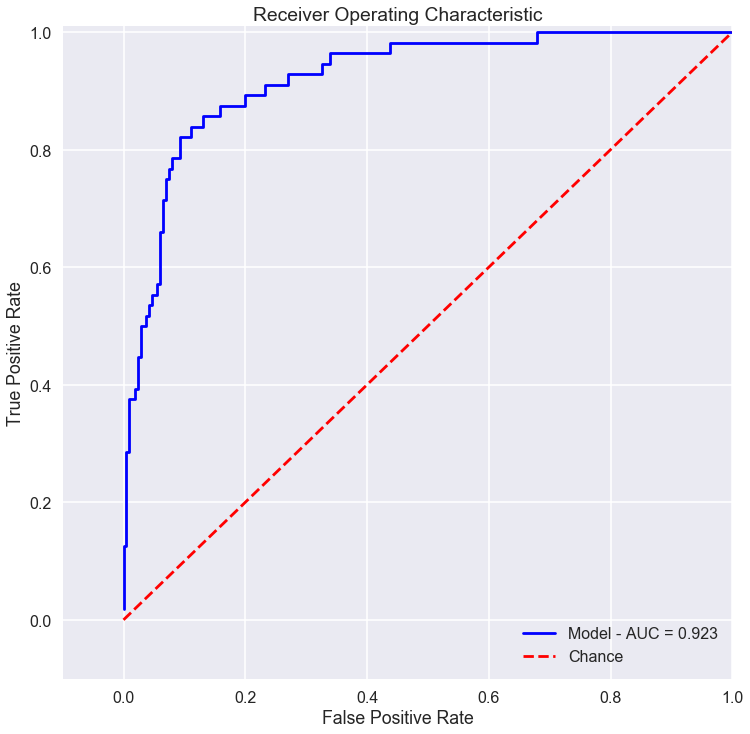

In [34]:
draw_roc_auc(model_ada)